# Particle Generation

## Import packages

In [1]:
import numpy as np
import scipy
from scipy import special
from zfel.particles import load_bucket
import matplotlib.pyplot as plt

## Input parameters

In [2]:
# Most standard
Nruns=1                             # Number of runs
npart   = 512                       # n-macro-particles per bucket 
s_steps = 200#31                    # n-sample points along bunch length
z_steps = 200#20                    # n-sample points along undulator
energy  = 4313.34*1E6               # electron energy [eV]
eSpread = 0#1.0e-4                  # relative rms energy spread [ ]
emitN   = 1.2e-6                    # normalized transverse emittance [m-rad]
currentMax = 3900                   # peak current [Ampere]
beta = 26                           # mean beta [meter]
unduPeriod = 0.03                   # undulator period [meter]
unduK = 3.5                         # undulator parameter, K [ ]
unduL = 70#30                       # length of undulator [meter]
radWavelength = 1.5e-9              # seed wavelength? [meter], used only in single-freuqency runs
dEdz = 0                            # rate of relative energy gain or taper [keV/m], optimal~130
iopt = 5                            # 5=SASE, 4=seeded
P0 = 10000*0.0                      # small seed input power [W]
constseed = 1                       # whether we want to use constant random seed for reproducibility, 1 Yes, 0 No
# particle information with positions in meter and gamma,\
# if we want to load random particle positions and energy, then set None
hist_rule='square-root'             # 'square-root' or 'sturges' or 'rice-rule' or 'self-design', number \
                                    #  of intervals to generate the histogram of gamma value in a bucket

In [3]:
# for pytorch optimization
Nruns=1                             # Number of runs
npart   = 512                       # n-macro-particles per bucket 
s_steps = 30#200#31                    # n-sample points along bunch length
z_steps = 30#200#20                    # n-sample points along undulator
energy  = 4313.34*1E6               # electron energy [eV]
eSpread = 0#1.0e-4                  # relative rms energy spread [ ]
emitN   = 1.2e-6                    # normalized transverse emittance [m-rad]
currentMax = 3900                   # peak current [Ampere]
beta = 26                           # mean beta [meter]
unduPeriod = 0.03                   # undulator period [meter]
#unduK = 3.5                        # undulator parameter, K [ ]
unduK = np.ones(z_steps)*3.5  # tapered undulator parameter, K [ ]
if unduK.shape[0]!=z_steps:
    print('Wrong! Number of steps should always be the same as z_steps')
unduL = 70#30                       # length of undulator [meter]
radWavelength = 1.5e-9              # seed wavelength? [meter], used only in single-freuqency runs

mc2 = 0.51099906E6#510.99906E-3      # Electron rest mass in eV

gamma0  = energy/mc2                                    # central energy of the beam in unit of mc2
    
radWavelength=unduPeriod*(1+unduK[0]**2/2.0)\
                    /(2*gamma0**2)                          # resonant wavelength

print(radWavelength)
dEdz = 0                            # rate of relative energy gain or taper [keV/m], optimal~130
iopt = 'sase'                       # 'sase' or 'seeded'
P0 = 10000*0.0                      # small seed input power [W]
constseed = 1                       # whether we want to use constant random seed for reproducibility, 1 Yes, 0 No
particle_position=None#genfromtxt('./Inputs/particle_position.csv', delimiter=',') # or None  
# particle information with positions in meter and eta,\
# if we want to load random particle positions and energy, then set None
hist_rule='square-root'             # 'square-root' or 'sturges' or 'rice-rule' or 'self-design', number \
                                    #  of intervals to generate the histogram of eta value in a bucket

1.4999920058175574e-09


## Calculating intermediate parameters

In [4]:
mc2 = 0.51099906E6#510.99906E-3      # Electron rest mass in eV
c = 2.99792458E8        # light speed in meter
e = 1.60217733E-19      # electron charge in Coulomb
gamma0  = energy/mc2                                    # central energy of the beam in unit of mc2
resWavelength = unduPeriod*(1+unduK[0]**2/2.0)\
                    /(2*gamma0**2)                          # resonant wavelength
coopLength = resWavelength/unduPeriod                # cooperation length
gainLength = 1                                      # rough gain length
z0    = unduL/gainLength                                # wiggler length in units of gain length
delt  = z0/z_steps                                      # integration step in z0 ~ 0.1 gain length
dels  = delt                                            # integration step in s0 must be same as in z0 
s = np.arange(1,s_steps+1)*dels*coopLength*1.0e6        # longitundinal steps along beam in micron ? meter           
z = np.arange(1,z_steps+1)*delt*gainLength              # longitundinal steps along undulator in meter
bunchLength=s[-1]*1e-6

gbar  = (resWavelength-radWavelength)\
            /(radWavelength)                                # scaled detune parameter
delg  = eSpread                                         # Gaussian energy spread in units of rho 
Ns    = currentMax*unduL/unduPeriod/z_steps\
            *resWavelength/c/e                              # N electrons per s-slice [ ]

## Generate particle profile

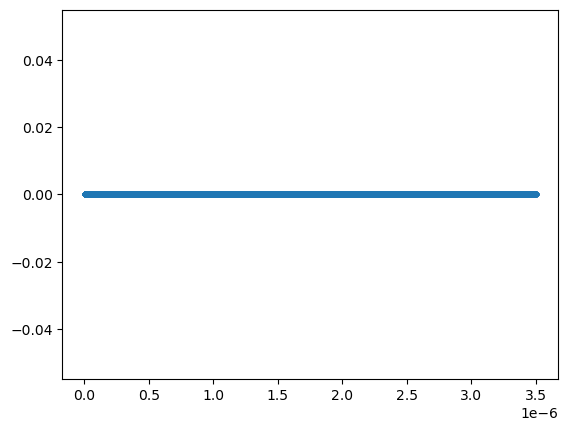

In [5]:
# SASE_particle_position
s_all=np.zeros((npart*s_steps,1))
gam_all=np.zeros((npart*s_steps,1))
for j in range(s_steps):
    [thet0,eta0] = load_bucket(npart,gbar,delg,Ns, iopt=iopt)     # load each bucket
    for n in range(npart):
        s_all[j*npart+n,0]=(j+thet0[n]/(2*np.pi))*dels*coopLength
        gam_all[j*npart+n,0]=eta0[n]

SASE_particle_position=np.concatenate((s_all,gam_all),axis=1)
plt.figure()
plt.plot(s_all,gam_all,'.')
np.savetxt("./data/SASE_particle_position.csv", SASE_particle_position, delimiter=",")


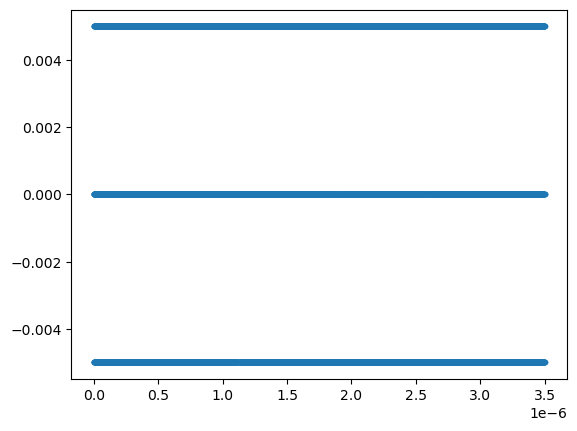

In [6]:
# weird_particle_position
particle_num=npart*s_steps
s_all=np.random.rand(particle_num,1)*bunchLength
gam_all=np.zeros((particle_num,1))
gam_all[:int(particle_num/3),0]+=0.005
gam_all[int(2*particle_num/3):,0]-=0.005
weird_particle_position=np.concatenate((s_all,gam_all),axis=1)
plt.figure()
plt.plot(s_all,gam_all,'.')
np.savetxt("weird_particle_position.csv", weird_particle_position, delimiter=",")

In [7]:
# Cleanup
!rm weird_particle_position.csv